In [62]:
import tensorflow as tf
from tensorflow import keras
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import sys
sys.path.insert(1,'c:/Users/h2pro/Programming')
import StockPull
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

#load data
company = 'msft'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)

data = StockPull.analysisout(company)
df = data

In [63]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:3]
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
# print(train_data)
print(df_for_training)

1243   2022-11-16
1244   2022-11-17
1245   2022-11-18
1246   2022-11-21
1247   2022-11-22
1248   2022-11-23
1249   2022-11-25
1250   2022-11-28
1251   2022-11-29
1252   2022-11-30
1253   2022-12-01
1254   2022-12-02
1255   2022-12-05
1256   2022-12-06
1257   2022-12-07
Name: Date, dtype: datetime64[ns]
           Price      Volume
0      79.254723  24489100.0
1      80.262337  22857900.0
2      80.591972  23924100.0
3      80.375366  22062700.0
4      79.753830  19306000.0
...          ...         ...
1253  254.690002  26041500.0
1254  255.020004  21522800.0
1255  250.199997  23435300.0
1256  245.119995  22463700.0
1257  244.369995  20472000.0

[1258 rows x 2 columns]


In [64]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [65]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 60  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1198, 60, 2).
trainY shape == (1198, 1).


In [66]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=25, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 64)            17152     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
68/68 [==============================] - 3s 20ms/step - loss: 0.2570 - val_loss: 0.0336
Epoch 2/25
68/68 [==============================] - 1s 18ms/step - loss: 0.0475 - v

In [67]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 300
n_days_for_prediction=n_past+1  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

[Timestamp('2021-09-30 00:00:00', freq='C'), Timestamp('2021-10-01 00:00:00', freq='C'), Timestamp('2021-10-04 00:00:00', freq='C'), Timestamp('2021-10-05 00:00:00', freq='C'), Timestamp('2021-10-06 00:00:00', freq='C'), Timestamp('2021-10-07 00:00:00', freq='C'), Timestamp('2021-10-08 00:00:00', freq='C'), Timestamp('2021-10-12 00:00:00', freq='C'), Timestamp('2021-10-13 00:00:00', freq='C'), Timestamp('2021-10-14 00:00:00', freq='C'), Timestamp('2021-10-15 00:00:00', freq='C'), Timestamp('2021-10-18 00:00:00', freq='C'), Timestamp('2021-10-19 00:00:00', freq='C'), Timestamp('2021-10-20 00:00:00', freq='C'), Timestamp('2021-10-21 00:00:00', freq='C'), Timestamp('2021-10-22 00:00:00', freq='C'), Timestamp('2021-10-25 00:00:00', freq='C'), Timestamp('2021-10-26 00:00:00', freq='C'), Timestamp('2021-10-27 00:00:00', freq='C'), Timestamp('2021-10-28 00:00:00', freq='C'), Timestamp('2021-10-29 00:00:00', freq='C'), Timestamp('2021-11-01 00:00:00', freq='C'), Timestamp('2021-11-02 00:00:00'

In [68]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [69]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Price':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Price']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

C:\Users\h2pro\AppData\Local\Temp\ipykernel_9864\2407180210.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


c:\Users\h2pro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\h2pro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Price'>

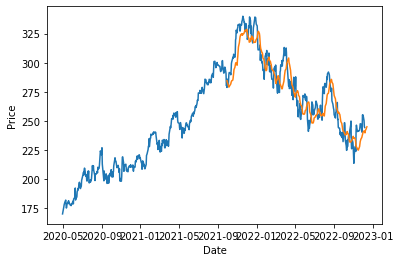

In [70]:
sns.lineplot(original['Date'], original['Price'])
sns.lineplot(df_forecast['Date'], df_forecast['Price'])